In [1]:
import bs4 as bs
import seaborn as sns
import requests
import pandas_datareader as pdr
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from finta import TA
import math


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, recall_score, f1_score

import warnings
from module import *

warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Establish a starting date and end date to pull asset data from
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()
# Establish a variable with the ticker of the stock we are wanting to analyze
stock = 'TSLA'
# Utilize pandas datareader to import financial data
data = pdr.DataReader(stock, 'yahoo', start, end)

# Calculate Moving Averages

In [3]:
# Organize data into a pandas DataFrame
df = pd.DataFrame(index = data.index)
df.head()

""
Date
2010-06-29
2010-06-30
2010-07-01
2010-07-02
2010-07-06


In [4]:
# Establish a timeline for our short and long-term moving average windows
short_window = 50
long_window = 200
# Establish new features using Pandas moving average methods
df['short_avg'] = data['Close'].ewm(span = 50, adjust = False).mean()
df['long_avg'] = data['Close'].ewm(span = 200, adjust = False).mean()
# Include the difference in a new feature for short and long moving average
df['difference'] = df.short_avg - df.long_avg
df['cross'] = np.sign(df.difference.shift(1))!=np.sign(df.difference)

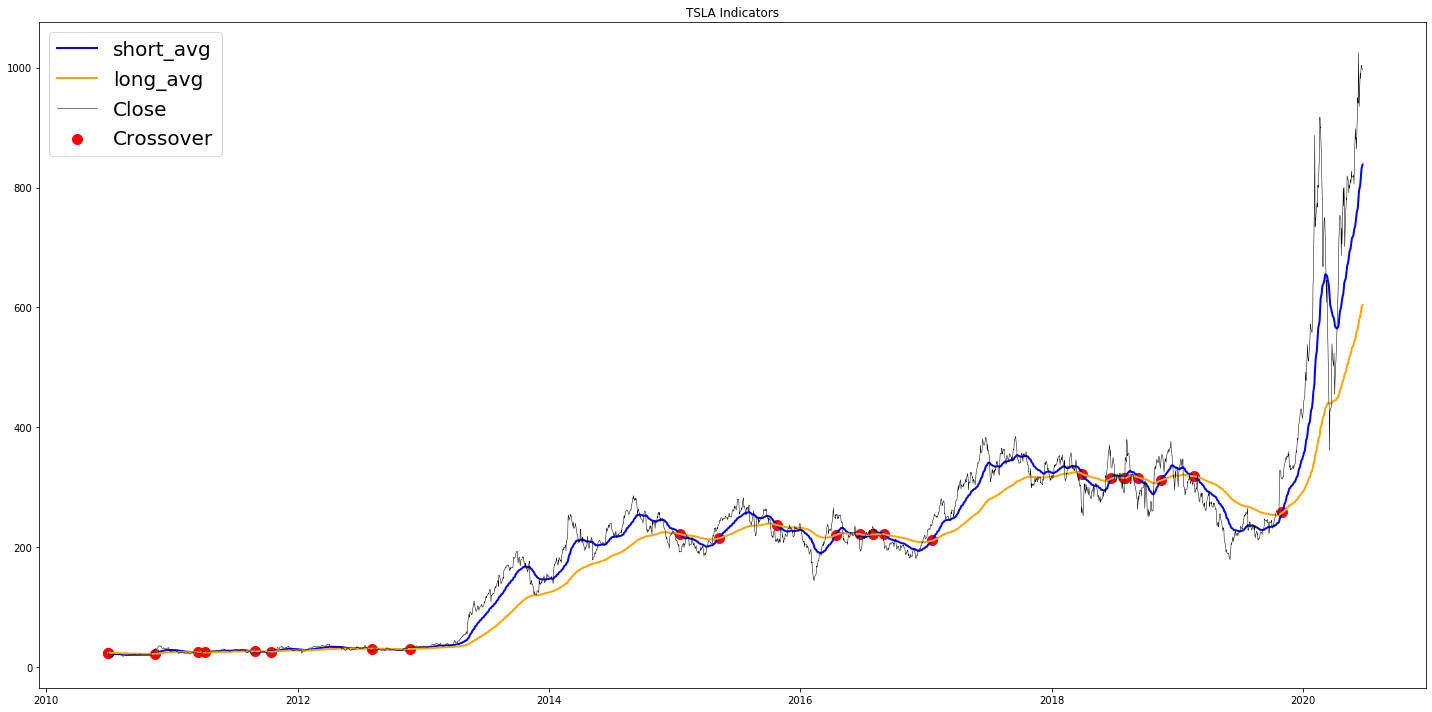

In [5]:
# Plot long term moving average, short term moving average, closing prices, and crossover points
plt.figure(figsize = (20,10))
plt.scatter(df[df.cross == True].index, df[df.cross==True].short_avg, color = 'red', s = 100, label = 'Crossover')
plt.plot(df.short_avg, 'blue', lw = 2, label = 'short_avg')
plt.plot(df.long_avg, 'orange', lw = 2, label = 'long_avg')
plt.plot(data.Close, 'black', label = 'Close', lw = 0.5)

plt.title(f"{stock} Indicators")
plt.legend(loc = 'upper left', fontsize = 20)
plt.tight_layout()

# ML

In [6]:
SP = pdr.DataReader('SPY', 'yahoo', start, end)
SP['sp_pct_change'] = SP['Adj Close'].pct_change(periods = 1).astype(float)
data = data.merge(SP['sp_pct_change'], left_index = True, right_index = True)
data['pct_change'] = data['Adj Close'].pct_change(periods = 1).astype(float)
data['relative_change'] = data['pct_change'] - data['sp_pct_change']
data.reset_index(inplace = True)
data.columns = [x.lower() for x in data.columns]
data.to_csv('data.csv')

In [7]:
data.head()

,date,high,low,open,close,volume,adj close,sp_pct_change,pct_change,relative_change
0,2010-06-29,25.00,17.540001,19.000000,23.889999,18766300,23.889999,-0.030875,NaN,NaN
1,2010-06-30,30.42,23.299999,25.790001,23.830000,17187100,23.830000,-0.009500,-0.002511,0.006989
2,2010-07-01,25.92,20.270000,25.000000,21.959999,8218800,21.959999,-0.004456,-0.078473,-0.074016
3,2010-07-02,23.10,18.709999,23.000000,19.200001,5139800,19.200001,-0.005450,-0.125683,-0.120233
4,2010-07-06,20.00,15.830000,20.000000,16.110001,6866900,16.110001,0.006556,-0.160938,-0.167493


# Add Indicators

In [8]:
indicators = ['SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'VAMA', 'ER', 'KAMA', 
              'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'VWAP', 'SMMA', 'MACD', 'PPO', 'VW_MACD', 'EV_MACD',
              'MOM', 'ROC', 'RSI', 'IFT_RSI']

broken_indicators = []

In [9]:
for indicator in indicators:
    if indicator not in broken_indicators:
        df = None
        df = eval('TA.' + indicator + '(data)')
        
        if not isinstance(df, pd.DataFrame):
            df = df.to_frame()
            
        df = df.add_prefix(indicator + '_')
        data = data.merge(df, left_index = True, right_index = True)

data.columns = data.columns.str.replace(' ', '_')

In [10]:
data.head()

,date,high,low,open,close,volume,adj_close,sp_pct_change,pct_change,relative_change,...,PPO_SIGNAL,PPO_HISTO,VW_MACD_MACD,VW_MACD_SIGNAL,EV_MACD_MACD,EV_MACD_SIGNAL,MOM_MOM,ROC_ROC,RSI_RSI,IFT_RSI_IFT_RSI
0,2010-06-29,25.00,17.540001,19.000000,23.889999,18766300,23.889999,-0.030875,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN
1,2010-06-30,30.42,23.299999,25.790001,23.830000,17187100,23.830000,-0.009500,-0.002511,0.006989,...,-0.003135,-0.002508,-0.001351,-0.000750,0.0,0.0,NaN,NaN,0.0,NaN
2,2010-07-01,25.92,20.270000,25.000000,21.959999,8218800,21.959999,-0.004456,-0.078473,-0.074016,...,-0.107425,-0.150179,-0.044206,-0.018560,0.0,0.0,NaN,NaN,0.0,NaN
3,2010-07-02,23.10,18.709999,23.000000,19.200001,5139800,19.200001,-0.005450,-0.125683,-0.120233,...,-0.354185,-0.481674,-0.133640,-0.057544,0.0,0.0,NaN,NaN,0.0,NaN
4,2010-07-06,20.00,15.830000,20.000000,16.110001,6866900,16.110001,0.006556,-0.160938,-0.167493,...,-0.782802,-1.012223,-0.355323,-0.146126,0.0,0.0,NaN,NaN,0.0,NaN


# Add short term stock results in relation to current positon

In [11]:
data['short_result'] = None
for index, row in data.iterrows():
    percent_change = data.loc[index + 1:index + 30]['relative_change'].sum()*100
    if math.isnan(percent_change):
        percent_change = 0
    else:
        percent_change = int(round(percent_change))
    data.at[index, 'short_result'] = percent_change
del data['relative_change']

In [12]:
data = data[40:]

# Prepping Data

**Classification KEY:**
* 0 = Buy
* 1 = Hold
* 2 = Sell
* 3 = Strong Buy
* 4 = Strong Sell

In [13]:
bins = [-300, -11, -5, 5, 11, 300]
groups = ['strong sell', 'sell', 'hold', 'buy', 'strong buy']
data['short_result'] = pd.cut(data['short_result'], bins = bins, labels = groups)

In [14]:
data.short_result.value_counts()

strong buy     751
hold           662
strong sell    428
sell           342
buy            290
Name: short_result, dtype: int64

In [15]:
label_encoder = LabelEncoder()
data.short_result = label_encoder.fit_transform(data.short_result)

In [16]:
data.short_result.value_counts()

3    751
1    662
4    428
2    342
0    290
Name: short_result, dtype: int64

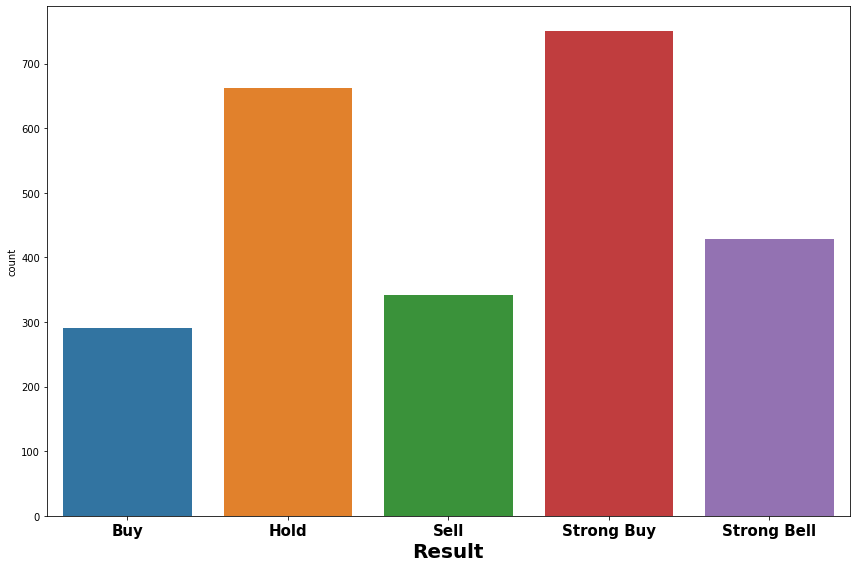

In [17]:
plt.figure(figsize = (12,8))
a = sns.countplot(data.short_result)
a.set_xticklabels(['Buy', 'Hold', 'Sell', 'Strong Buy', 'Strong Bell'], fontsize = 15, fontweight = 'bold')
a.set_xlabel('Result', fontsize = 20, fontweight = 'bold')
plt.tight_layout()